In [1]:
# This reads in some scraped data and produces final data to plot,
# as a check on the class findHK()

# This should be used in conjunction with test_scrape_ew_and_errew.py

# Created 2019 Apr 13 by E.S.

In [2]:
import numpy as np
import pandas as pd
import configparser
import matplotlib.pyplot as plt

In [3]:
from rrlyrae_metallicity.modules2 import *

In [4]:
# configuration data
config = configparser.ConfigParser() # for parsing values in .init file
config.read("../rrlyrae_metallicity/modules2/config.ini")

['../rrlyrae_metallicity/modules2/config.ini']

In [5]:
stem = ("/Users/nyumbani/Documents/git.repos/rrlyrae_metallicity/"+\
    "rrlyrae_metallicity/tests/test_robospect_output")

In [6]:
# fake EW data (note this is with the fake 'bad' data removed)

scraped_EW_filename = config["data_dirs"]["TEST_DIR_ROBO_OUTPUT"] + config["file_names"]["MCD_LARGE_BAD_REMOVED"]
data = pd.read_csv(scraped_EW_filename)

fake_phases_filename = config["data_dirs"]["TEST_DIR_SRC"] + config["file_names"]["DETACHED_PHASES"]
phases = pd.read_csv(fake_phases_filename)

In [7]:
# append list of star names 

# first reproduce the spectrum names
data["star_name"] = data["empir_spec_name"]

for p in range(0,len(data["star_name"])):
    data.loc[p,["star_name"]] = str(data["star_name"][p])[0:-3]

In [8]:
# get the unique, 'good' spectrum names 

unique_good_empir_spec_names = data["empir_spec_name"].drop_duplicates().dropna().reset_index(drop=True) 

In [9]:
# get the unique star names 

unique_star_names = data.dropna().drop_duplicates(subset=["star_name"])["star_name"].values

In [10]:
# separate the data by absorption line

data_Heps = data.where(data["line_name"] == "Heps").dropna().reset_index(drop=True) 
data_Hdel = data.where(data["line_name"] == "Hdel").dropna().reset_index(drop=True) 
data_Hgam = data.where(data["line_name"] == "Hgam").dropna().reset_index(drop=True) 
data_Hbet = data.where(data["line_name"] == "Hbet").dropna().reset_index(drop=True) 
data_CaIIK = data.where(data["line_name"] == "CaIIK").dropna().reset_index(drop=True) 

In [11]:
# fit line to Hgamma (y) vs Hdelta (x)

m, b = np.polyfit(data_Hdel["EQW"], data_Hgam["EQW"], 1)

In [12]:
# initialize the dataframe which will hold the data to plot
# (each row in this dataframe will represent one synthetic spectrum)

KH_synthetic_data = pd.DataFrame()

In [13]:
# make rescaled Hgamma: Hgamma’ = (Hgamma - b)/m
# ... and be sure to associate an empirical spectrum name with each

KH_synthetic_data["rHgam"] = np.divide(np.subtract(data_Hgam["EQW"],b),m)
KH_synthetic_data["empir_spec_name"] = data_Hgam["empir_spec_name"]
KH_synthetic_data["synth_spec_name"] = data_Hgam["synth_spec_name"]

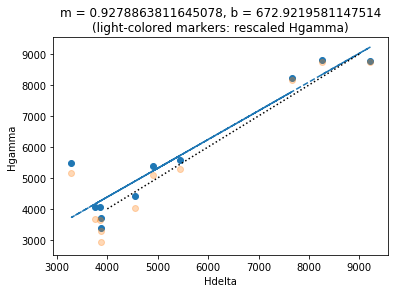

In [14]:
# plot Hgamma vs Hdelta before and after rescaling,
# for all synthetic spectra

plt.scatter(data_Hdel["EQW"], data_Hgam["EQW"])
plt.scatter(data_Hdel["EQW"], KH_synthetic_data["rHgam"], marker="o", alpha=0.3)
plt.plot(data_Hdel["EQW"], np.add(np.multiply(m,data_Hdel["EQW"]),b), linestyle="--")
plt.plot([4000,9000], [4000,9000], linestyle=":", color="k") # 1-to-1
plt.xlabel("Hdelta")
plt.ylabel("Hgamma")
plt.title("m = " + str(m) + ", b = " + str(b) + "\n(light-colored markers: rescaled Hgamma)")
plt.show()

In [15]:
# plug in the CaIIK data

# initialize
KH_synthetic_data["CaIIK"] = np.nan*KH_synthetic_data["rHgam"]
KH_synthetic_data["Hdel"] = np.nan*KH_synthetic_data["rHgam"]
KH_synthetic_data["Hgam"] = np.nan*KH_synthetic_data["rHgam"]

# loop over synthetic spectra names and pick out the data for the other lines
for p in range(0,len(KH_synthetic_data["CaIIK"])):
    caiik_here = np.copy(data_CaIIK["EQW"].where(
        data_CaIIK["synth_spec_name"] == KH_synthetic_data["synth_spec_name"].loc[p]).dropna().values)
    Hdel_here = np.copy(data_Hdel["EQW"].where(
        data_Hdel["synth_spec_name"] == KH_synthetic_data["synth_spec_name"].loc[p]).dropna().values)
    Hgam_here = np.copy(data_Hgam["EQW"].where(
        data_Hgam["synth_spec_name"] == KH_synthetic_data["synth_spec_name"].loc[p]).dropna().values)
    KH_synthetic_data.loc[p, ["CaIIK"]] = caiik_here # note the .loc syntax here to avoid operating on a copy
    KH_synthetic_data.loc[p, ["Hdel"]] = Hdel_here 
    KH_synthetic_data.loc[p, ["Hgam"]] = Hgam_here 

In [16]:
# calculate a net Balmer line: average between Hdel and re-scaled Hgam

KH_synthetic_data["Balmer"] = np.mean([KH_synthetic_data["rHgam"].values,KH_synthetic_data["Hdel"].values], axis=0)

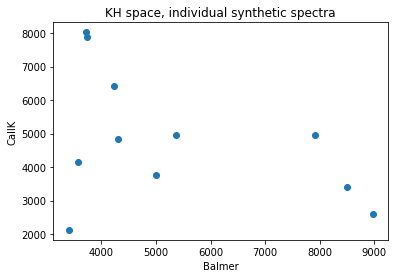

In [18]:
# plot KH space, plotting all synthetic spectra separately
# (note this will not involve error bars)

plt.clf()
plt.scatter(KH_synthetic_data["Balmer"], KH_synthetic_data["CaIIK"])
plt.xlabel("Balmer")
plt.ylabel("CaIIK")
plt.title("KH space, individual synthetic spectra")
plt.show()

In [19]:
# calculate median points, with error bars, for each empirical spectrum

# initialize arrays
empir_spec_name_array = []
Balmer_array = []
CaIIK_array = []
err_Balmer_array = []
err_CaIIK_array = []
phase_array = []

# loop over each empirical spectrum
for empir_num in range(0,len(unique_good_empir_spec_names)):
    
    data_for_this_empir_spectrum = KH_synthetic_data.where(
        KH_synthetic_data["empir_spec_name"] == np.array(unique_good_empir_spec_names)[empir_num]
    )
    
    empir_spec_name_array = np.concatenate((empir_spec_name_array, [np.array(unique_good_empir_spec_names)[empir_num]]))
    Balmer_array = np.concatenate((Balmer_array,[np.nanmedian(data_for_this_empir_spectrum["Balmer"])]))
    CaIIK_array = np.concatenate((CaIIK_array,[np.nanmedian(data_for_this_empir_spectrum["CaIIK"])]))
    err_Balmer_array = np.concatenate((err_Balmer_array,[np.nanstd(data_for_this_empir_spectrum["Balmer"])]))
    err_CaIIK_array = np.concatenate((err_CaIIK_array,[np.nanstd(data_for_this_empir_spectrum["CaIIK"])]))
    
    phase_here = phases["phase"].where(
        phases["Spectrum"] == np.array(unique_good_empir_spec_names)[empir_num]).dropna().values
    phase_array = np.concatenate((phase_array,phase_here))
    
# cobble into a single dataframe ('reduced' because each row corresponds to an empirical spectrum)
KH_reduced_data = pd.DataFrame({"Balmer":Balmer_array, 
                                "CaIIK":CaIIK_array, 
                                "err_Balmer":err_Balmer_array, 
                                "err_CaIIK":err_CaIIK_array,
                                "empir_spec_name": empir_spec_name_array,
                                "star_name": empir_spec_name_array,
                                "phase": phase_array})

# add the star names
for p in range(0,len(KH_reduced_data["star_name"])):
    KH_reduced_data.loc[p,["star_name"]] = str(KH_reduced_data["empir_spec_name"][p])[0:-3]

In [20]:
## ## why does this not work in Notebook?
#min_good_phase, max_good_phase = phase_regions()

In [21]:
# EW data with good phases
# (is this even necessary?)

KH_reduced_data_good_phase = KH_reduced_data.where(np.logical_and(
        KH_reduced_data["phase"] > config.getfloat("phase", "MIN_GOOD"),
        KH_reduced_data["phase"] < config.getfloat("phase", "MAX_GOOD"))).dropna()

In [23]:
# EW data with bad phases
# (is this even necessary?)

KH_reduced_data_bad_phase = KH_reduced_data.where(np.logical_or(
        KH_reduced_data["phase"] < config.getfloat("phase", "MIN_GOOD"),
        KH_reduced_data["phase"] > config.getfloat("phase", "MAX_GOOD"))).dropna()

0    all_good
1    all_good
Name: star_name, dtype: object
2    bad_hbeta_wavel
Name: star_name, dtype: object
3    fit_center_flag
Name: star_name, dtype: object


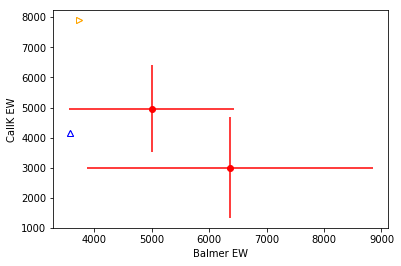

In [24]:
# plot KH space

colors = ['red', 'blue', 'orange', 'teal', 'black', 'green', 'purple']*10
markers = ['o', '^', '>', 's', '<']*10
cmap = plt.get_cmap(name='jet')

for star_num in range(0,len(unique_star_names)):
    
    # get data on all the empirical spectra for this star
    data_this_star = KH_reduced_data.where(KH_reduced_data["star_name"] == unique_star_names[star_num]).dropna()
    
    print(data_this_star["star_name"])
    
    color_this_star = cmap(float(star_num)/len(unique_star_names))
    
    plt.errorbar(data_this_star["Balmer"],data_this_star["CaIIK"],
                 xerr=data_this_star["err_Balmer"],yerr=data_this_star["err_CaIIK"],
                 linestyle='',fmt=markers[star_num],markerfacecolor=colors[star_num],color=colors[star_num])
    
    # overplot empty markers if phase region is bad
    bad_phase_regs = data_this_star[
        np.logical_or(data_this_star["phase"] < config.getfloat("phase", "MIN_GOOD"),
                      data_this_star["phase"] > config.getfloat("phase", "MAX_GOOD"))
    ]
    plt.errorbar(bad_phase_regs["Balmer"],bad_phase_regs["CaIIK"],
                 linestyle='',fmt=markers[star_num],markerfacecolor="white",color=colors[star_num])

    #plt.annotate(unique_star_names[star_num], xy=(data_this_star["Balmer"],data_this_star["CaIIK"]))

plt.ylabel("CaIIK EW")
plt.xlabel("Balmer EW")
plt.show()